In [327]:
!pip install geopandas && pip install formulaic

156149.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [328]:
from formulaic import Formula

In [329]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Procesamiento de datos

In [330]:
datos = pd.read_csv('sube-2023.csv')
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


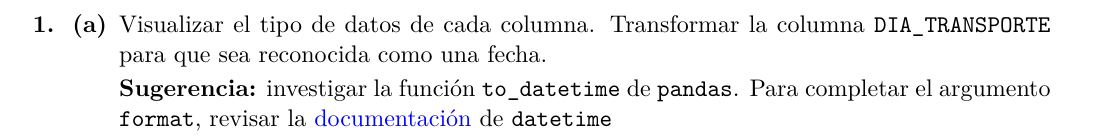

In [331]:
# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

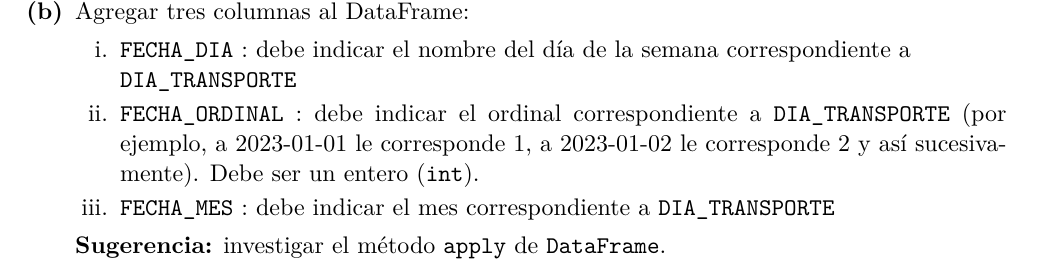

In [332]:
# Agregamos a nuestra DataFrame las columnas indicadas

# Agregamos la columna de fecha_dia con el formato observado en el ejemplo, solamente con 3 carácteres
datos['fecha_dia'] = datos['DIA_TRANSPORTE'].dt.day_name().str[:3]
# Agregamos la columna de fecha_mes en formato 'MM', 2 dígitos para el mes
datos['fecha_mes'] = datos['DIA_TRANSPORTE'].dt.strftime('%m')
# Agregamos la columna de fecha_ordinal indicando el día ordinal del año
datos['fecha_ordinal'] = datos['DIA_TRANSPORTE'].dt.dayofyear

In [333]:
# Tests
# DIA_TRANSPORTE tiene que ser tipo datetime
assert datos['DIA_TRANSPORTE'].dtype == 'datetime64[ns]'

# Dias de la semana
assert datos['fecha_dia'].drop_duplicates().count() == 7 # Tienen que ser 7 dias distintos

# Tiene que haber 365 dias distintos en el año
assert datos['fecha_ordinal'].drop_duplicates().count() == 365


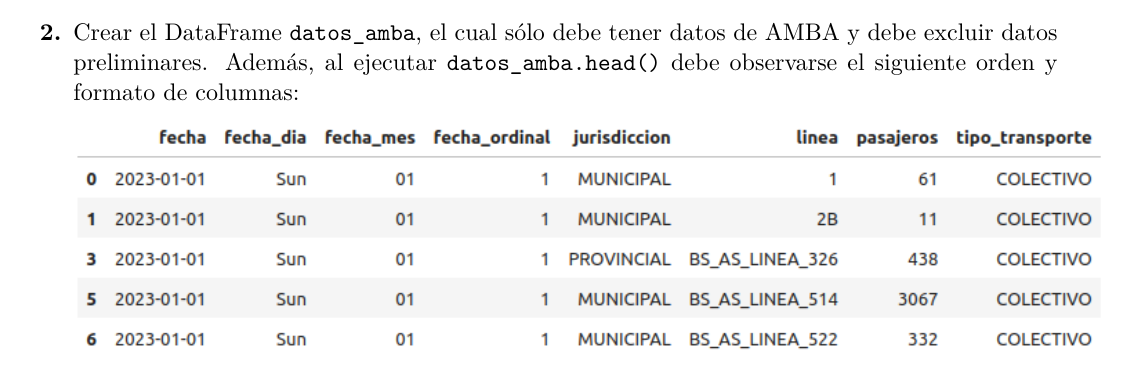

In [334]:
#Creamos un nuevo data frame con los valores a trabajar solicitados.
datos_filtrados = datos[datos['DATO_PRELIMINAR'] == "NO"]

In [335]:
datos_filtrados.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,fecha_dia,fecha_mes,fecha_ordinal
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Sun,01,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Sun,01,1
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO,Sun,01,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Sun,01,1
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO,Sun,01,1


In [336]:
#Seleccionamos las columnas correspondientes a visualizar.
column_order  = ['DIA_TRANSPORTE', 'fecha_dia', 'fecha_mes', 'fecha_ordinal', 'JURISDICCION', 'LINEA', 'CANTIDAD', 'TIPO_TRANSPORTE']
datos_amba = datos_filtrados[datos['AMBA'] == 'SI'][column_order]

# me guardo los datos totales por que me van a servir para mas adelante
datos_totales = datos_filtrados[column_order + ['AMBA']] # estos contiene todos los datos (amba y no amba)

/var/folders/l4/3t2ks6v96td59vlc8j7snwdm0000gn/T/ipykernel_9432/3735174321.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datos_amba = datos_filtrados[datos['AMBA'] == 'SI'][column_order]


In [338]:
#Renombramos las columnas correspondientes y colocamos el formato correcto.
datos_totales = datos_filtrados.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
datos_amba = datos_amba.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})

#Renombramos las columnas en un formato que sea minúsculas
datos_amba = datos_amba.rename(columns = str.lower)
datos_totales = datos_totales.rename(columns = str.lower)

In [339]:
#Visualizamos lo pedido
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


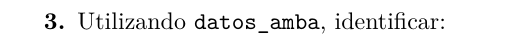

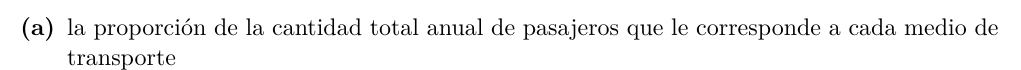

In [340]:
#Realizamos el agrupamiento correspondiente por tipo de transporte y pasajeros, calculando así su proporción
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum() / datos_amba['pasajeros'].sum()
print(proporcion_transporte)

tipo_transporte
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: pasajeros, dtype: float64


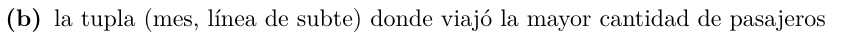

In [341]:
#Creamos un nuevo dataFrame donde sólo estén los datos del tipo de transporte "SUBTE" que se encuentran en el AMBA
subte_data = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']

In [342]:
#Realizamos las tuplas indicadas y sumamos la cantidad de pasajeros, según el mes y la línea
pasajeros_subte_mes = subte_data.groupby(['fecha_mes','linea'])['pasajeros'].sum()
#Localizamos la tupla con el valor máximo en cantidad de pasajeros
max_pasajeros_subte = pasajeros_subte_mes.idxmax()
#Nos quedamos con el valor que posee la mayor cantidad de pasajeros
max_value = pasajeros_subte_mes.max()
#Imprimimos el mes donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"El mes con la mayor cantidad de pasajeros fue: {max_pasajeros_subte[0]}")
#Imprimimos la línea donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"La línea de subte que tuvo la mayor cantidad de pasajeros fue : {max_pasajeros_subte[1]}")
#Imprimimos el valor máximo que hubo en cantidad de pasajeros
print(max_value)
#Imprimimos la tupla corresponidente indicada
print(max_pasajeros_subte)

El mes con la mayor cantidad de pasajeros fue: 08
La línea de subte que tuvo la mayor cantidad de pasajeros fue : LINEA_B
5227906
('08', 'LINEA_B')


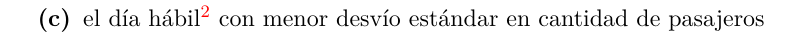

In [343]:
#Realizamos un nuevo DataFrame con los días hábiles a analizar.
días_hábiles = datos_amba[datos_amba['fecha_dia'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]
#Realizamos un agrupamiento por días y utilizamos la función std para calcular el desvío entandar en cada día.
desvio_hábiles = días_hábiles.groupby('fecha_dia')['pasajeros'].std()
#Nos quedamos con el valor mínimo.
dia_menor_desvio = desvio_hábiles.idxmin()
print(f"EL día hábil que posee el menor desvío estándar es: {dia_menor_desvio}")

EL día hábil que posee el menor desvío estándar es: Mon


# Análisis Exploratorio
#### Primero vamos a comparar como se distribuyen en argentina la cantidad de pasajeros (comparando por provincia) en el mapa de argentina
##### Queremos hacer un mapa de calor del territorio Argentino que muestre: $$\dfrac{pasajeros}{habitantes}$$

##### Para esto seguimos los siguientes pasos:
1. Importamos el geoJson de argentina y lo guardamos en un DataFrame
1. Guardamos en ese dataframe la cantidad de pasajeros (En sus respectivas provincias)
1. Obtenemos los datos de habitantes por provincia ([Fuente](https://censo.gob.ar/index.php/datos_definitivos/))
1. En el DataFrame calculamos agregamos una nueva columna "cantidad_proporcional" haciendo pasajers/habitantes
1. Finalmente hacemos el mapa de calor!

In [344]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests


df = gpd.read_file("https://labo-datos-next-psi.vercel.app/api/argentina/map") # Cargo el Mapa de argentina (devuelve un dataframe con columna nombre y las posiciones en el mapa)
datos_mapa = datos[(datos["PROVINCIA"] != "JN") & (datos["TIPO_TRANSPORTE"] == "COLECTIVO")] # Saco los de Jurisdiccion nacional ( no son muy signigicativos en el total 5% aprox)
datos_mapa = datos_mapa.groupby("PROVINCIA").sum("CANTIDAD") # Tomo los totales
df["nombre"] = df["nombre"].apply(str.upper) # pasamos a mayuscula los nombres del GEOJSON para poder comparar con las que ya tenemos
df["cantidad"] = [datos_mapa['CANTIDAD'][provincia] if provincia in datos_mapa.index else 0 for provincia in df["nombre"]] # agrego la columna cantidad al geojson

# Ahora le introducimos la poblacion de cada provincia (FUENTE https://censo.gob.ar/index.php/datos_definitivos/)
url_poblacion = "https://labo-datos-next-psi.vercel.app/api/argentina/poblacion"
response = requests.get(url_poblacion)
data_poblacion = pd.DataFrame(response.json())

# Sumamos CABA a Buenos Aires
habitantes_caba = data_poblacion[data_poblacion["provincia"] == "Ciudad Autónoma de Buenos Aires"]["habitantes"]
data_poblacion.iloc[data_poblacion[data_poblacion["provincia"] == "Buenos Aires"].index, 1] += habitantes_caba.values[0]
data_poblacion["provincia"] = data_poblacion["provincia"].apply(str.upper) # lo pasamos a mayuscula para poder comparar con el geojson
df["habitantes"] = [data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"].values[0] if len(data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"]) else 0  for provincia in df["nombre"]] # calculamos la proporcion de pasajeros por habitante
df["cantidad_proporcional"] = df["cantidad"] / df["habitantes"] # calculamos la proporcion de pasajeros por habitante

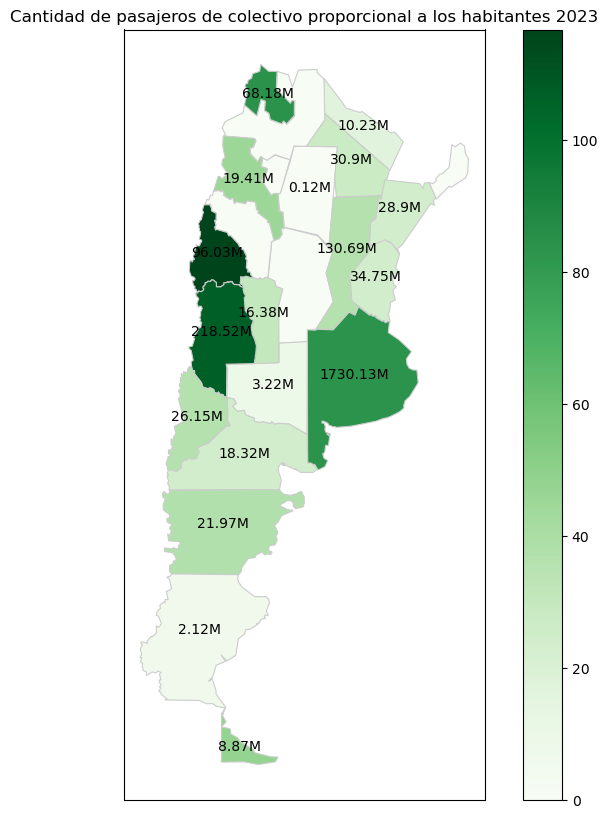

In [306]:
# Creo las figuras con matplolib ocultando ejes X e Y
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

df.plot(column='cantidad_proporcional', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

def million_format(n):
    if (n == 0):
        return ""

    return str(round(n/1000000, 2))+"M"

for i, row in df.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, million_format(row['cantidad']), horizontalalignment='center')
plt.title('Cantidad de pasajeros de colectivo proporcional a los habitantes 2023')
plt.show() # ((( No somos antipatria, no aparecen las malvinas por cuestiones del GEOJSON  )))


##### Notemos que BS.AS, Más allá de ser la provincia con mas pasajeros, y por mucha diferencia, en relación a la cantidad de habitantes no es que tiene mayor proporcion de pasajeros.


##### Ahora queremos responder la siguiente pregunta:
 * ¿Cómo varía el uso del transporte público a lo largo del año? ¿Se observa el mismo efecto en AMBA y en el interior del país? ¿Y en todos los medios de transporte por igual?
1. Para eso primero vamos a ver como varia en el AMBA durante el año, por mes y luego por dia de la semana


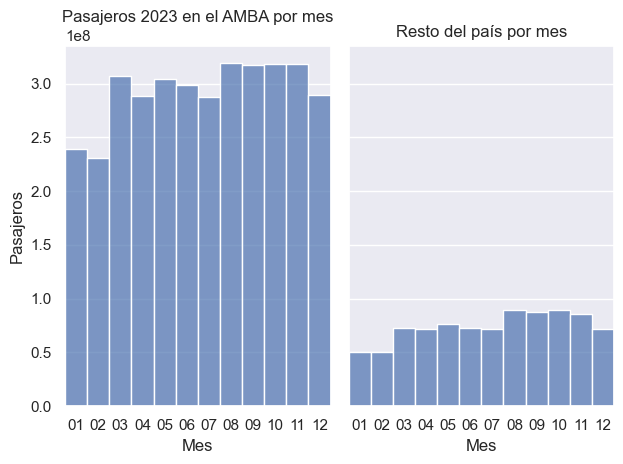

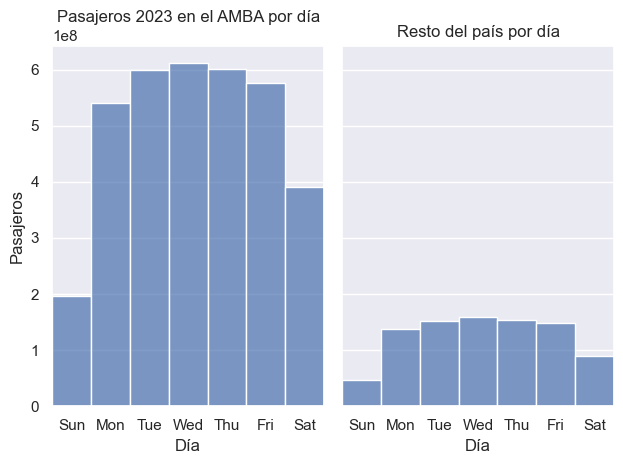

In [356]:
def titulo(amba, tiempo):
    title = "Pasajeros 2023"
    if (amba == "SI"):
        return f"{title} en el AMBA por {tiempo}"
    return f"Resto del país por {tiempo}"

so.Plot(datos_totales, x="fecha_mes", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(x="Mes", y="Pasajeros").facet("amba").label(title=lambda x: titulo(x, "mes")).show()
so.Plot(datos_totales, x="fecha_dia", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(x="Día", y="Pasajeros").facet("amba").label(title=lambda x: titulo(x, "día")).show()


##### Se ve claramente que en enero y febrero hay menos pasajeros, es algo de esperar suponiendo que muchas personas se toman vacaciones + receso escolar y universitario y una disminucion del uso del transporte publico los fines de semana. Más alla de la diferencia de cantidad, se ve la misma tendencia tanto en el amba como por fuera


In [308]:
# Ahora respondamos cual es la varianza de la cantidad de pasajeros en el AMBA durante el año 2023
varianza_amba = datos_amba['pasajeros'].var()
print(f"La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: {varianza_amba}")
# Ahora comparamos con la varianza en el resto de Argentina
datos_no_amba = datos[datos["AMBA"] == "NO"].dropna()
varianza_no_amba = datos_no_amba["CANTIDAD"].var()
print(f"La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: {varianza_no_amba}")

print(f"La varianza del amba es {round(varianza_amba/varianza_no_amba, 2)} mayor a la del resto de Argentina")


La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: 1016641795.392291
La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: 13214597.424150849
La varianza del amba es 76.93 mayor a la del resto de Argentina


##### Esto nos da una pista de la distribucion de los datos en el AMBA! se ve que los datos estan "Muy alejados entre si" en relacion al resto del país
##### Ahora queremos responder a la siguiente pregunta:  ¿Cómo difiere el uso del transporte público durante los días hábiles en comparación a los fines de semana?

count    149973.000000
mean      23463.016483
std       31884.820768
min        -417.000000
25%        5703.000000
50%       15495.000000
75%       30038.000000
max      542616.000000
Name: pasajeros, dtype: float64

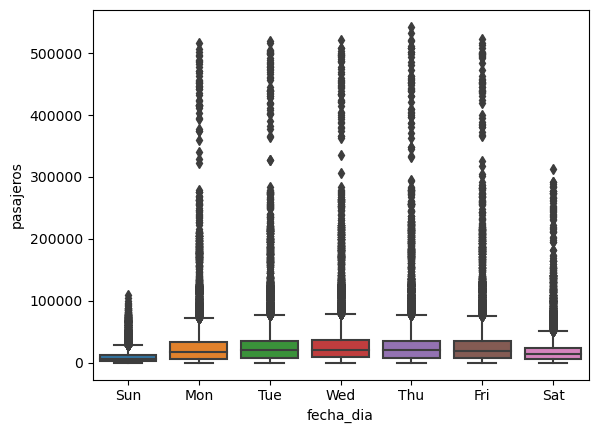

In [382]:
# Comparemos el uso del transpote publico dias habiles vs fines de semana
datos_totales.groupby("fecha_dia")["pasajeros"].sum()
sns.boxplot(x="fecha_dia", y="pasajeros", data=datos_amba)
outliers = datos_amba[datos_amba["pasajeros"] > datos_amba["pasajeros"].describe()["75%"]] # ESTO HAY QUE REVISARLO, PARA ENCONTRAR OUTLIERS
datos_amba["pasajeros"].describe()


##### ¿Cuál es el medio más utilizado y su proporción? ¿A qué se debe? ¿Será que posee mas lineas/empresas que el resto?

##### ¿A qué se debe? ¿Será que posee mas lineas/empresas que el resto?

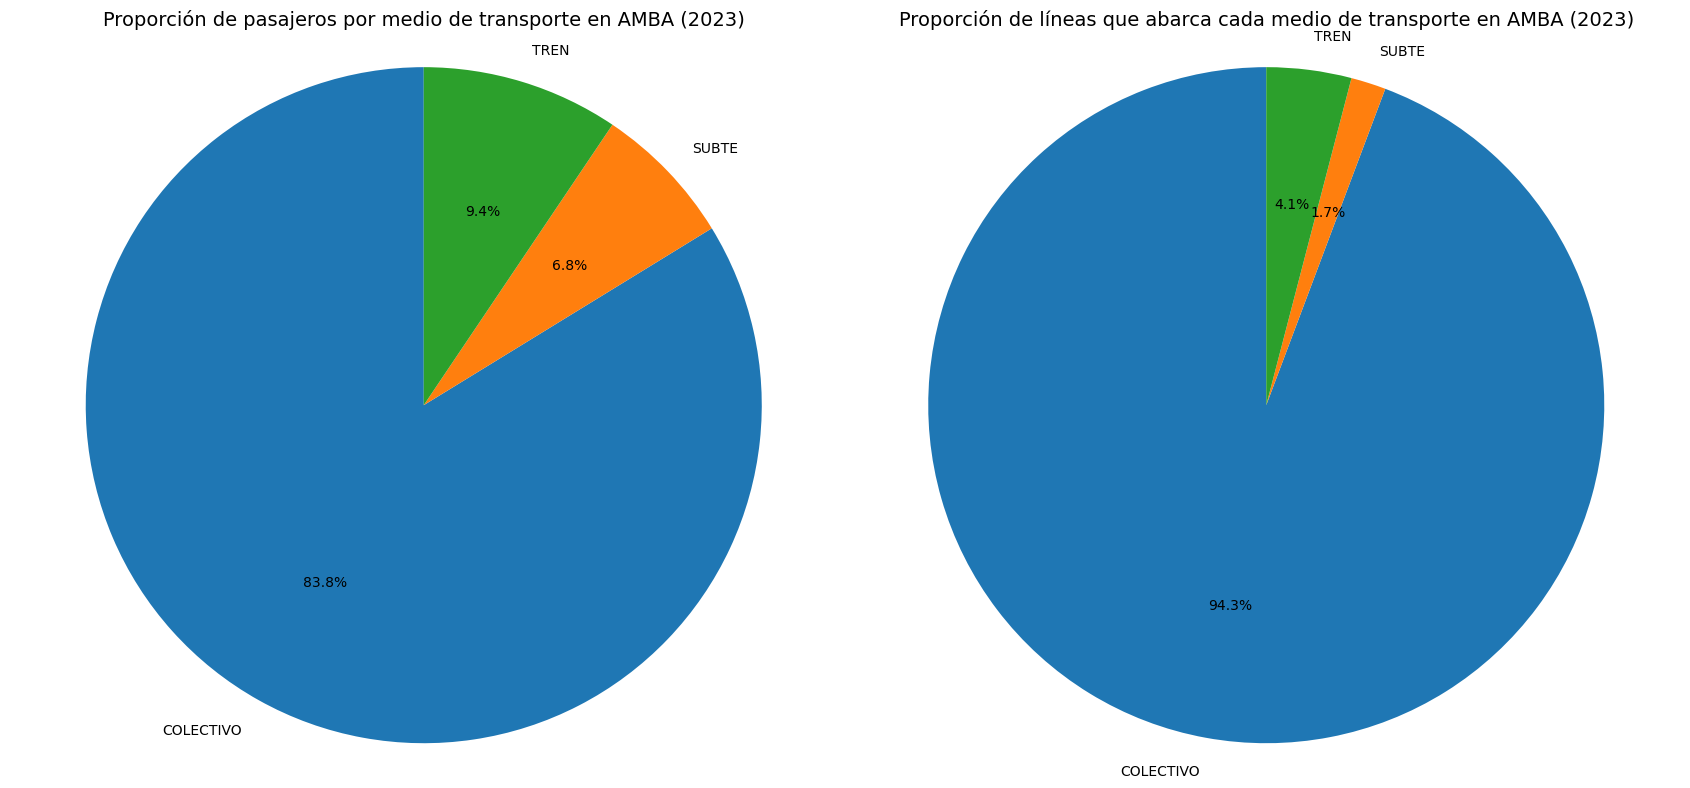

In [309]:
# Calculamos la proporción de pasajeros por cada tipo de transporte
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum().reset_index()
proporcion_transporte['proporcion'] = proporcion_transporte['pasajeros'] / datos_amba['pasajeros'].sum()

# Calcular la proporción de líneas que abarcan cada tipo de transporte
lineas_por_transporte_amba = datos_amba.groupby('tipo_transporte')['linea'].nunique().reset_index()
lineas_por_transporte_amba.columns = ['tipo_transporte', 'cantidad']

total_lineas_amba = lineas_por_transporte_amba['cantidad'].sum()
lineas_por_transporte_amba['proporcion'] = lineas_por_transporte_amba['cantidad'] / total_lineas_amba


fig, axs = plt.subplots(1, 2, figsize=(17, 8))

# Gráfico de torta para la proporción de pasajeros
axs[0].pie(proporcion_transporte['proporcion'], labels=proporcion_transporte['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Proporción de pasajeros por medio de transporte en AMBA (2023)', fontsize=14)
axs[0].axis('equal')

# Gráfico de torta para la proporción de líneas
axs[1].pie(lineas_por_transporte_amba['proporcion'], labels=lineas_por_transporte_amba['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Proporción de líneas que abarca cada medio de transporte en AMBA (2023)', fontsize=14)
axs[1].axis('equal')


plt.tight_layout()
plt.show()

#### Parecería indicar que el colectivo es el transporte que mayor movilidad de personas posee en función de la cantidad de líneas que abarca y ofrece en sus servicios. Ahora bien, nos preguntamos lo siguiente:
 ¿Cuál es la movilidad de personas que posee cada tipo de transporte en función de las líneas/servicios que posee?

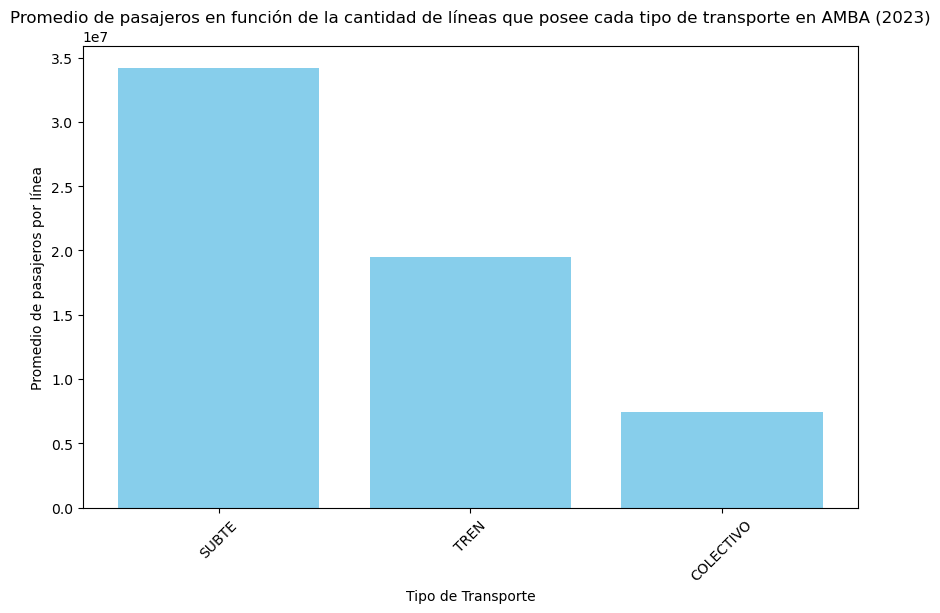

In [310]:
# Calculamos el promedio de pasajeros en función de la cantidad de líneas que tiene cada tipo de transporte
pasajeros_por_linea = proporcion_transporte.merge(lineas_por_transporte_amba, on='tipo_transporte')
pasajeros_por_linea['pasajeros_por_linea'] = pasajeros_por_linea['pasajeros'] / pasajeros_por_linea['cantidad']
pasajeros_por_linea

# Ordenamos por la cantidad de pasajeros por línea
pasajeros_por_linea = pasajeros_por_linea.sort_values(by='pasajeros_por_linea', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(pasajeros_por_linea['tipo_transporte'], pasajeros_por_linea['pasajeros_por_linea'], color='skyblue')
plt.xlabel('Tipo de Transporte')
plt.ylabel('Promedio de pasajeros por línea')
plt.title('Promedio de pasajeros en función de la cantidad de líneas que posee cada tipo de transporte en AMBA (2023)')
plt.xticks(rotation=45)
plt.show()

Es decir, podemos ver que el SUBTE en líneas generales es el que menor movilidad de personas posee en el año, pero a nivel de cantidad de líneas/servicios que ofrece es el que mayor cantidad de personas abarca en promedio. Esto puede deberse a una mayor eficiencia en términos de distancias recorridas/tiempos/costos

#### ¿Cúales son las empresas que poseen la mayor cantidad de pasajeros a nivel colectivos?

In [311]:
datos_2023 = pd.read_csv('sube-2023.csv')
datos_2023['DIA_TRANSPORTE'] = pd.to_datetime(datos_2023['DIA_TRANSPORTE'], format='%Y-%m-%d')
datos_2023['fecha_dia'] = datos_2023['DIA_TRANSPORTE'].dt.day_name().str[:3]
datos_2023['fecha_mes'] = datos_2023['DIA_TRANSPORTE'].dt.strftime('%m')
datos_2023['fecha_ordinal'] = datos_2023['DIA_TRANSPORTE'].dt.dayofyear
datos_2023 = datos_2023.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
datos_2023 = datos_2023.rename(columns = str.lower)


In [312]:
colectivos = datos_2023[(datos_2023['amba'] == 'SI') & (datos_2023['dato_preliminar'] == "NO") & (datos_2023['tipo_transporte'] == "COLECTIVO")]

In [315]:
# Agrupo por nombre de empresa y cuento la cantidad de pasajeros que acumuló cada empresa
pasajeros_por_empresa = colectivos.groupby('nombre_empresa')['pasajeros'].sum().reset_index()
pasajeros_por_empresa.columns = ['nombre_empresa', 'total_de_pasajeros']

# Agrupo por nombre de empresa y cuento la cantidad de líneas que posee cada empresa
lineas_por_empresa = colectivos.groupby('nombre_empresa')['linea'].nunique().reset_index()
lineas_por_empresa.columns = ['nombre_empresa', 'cantidad_de_líneas']

# Agrupo por nombre de empresa y cuento la cantidad de municipios que recorre cada empresa
zonas_por_empresa = colectivos.groupby('nombre_empresa')['municipio'].nunique().reset_index()
zonas_por_empresa.columns = ['nombre_empresa', 'cantidad_de_municipios']

# Uno el DataFrame de pasajeros_por_empresa y lineas_por_empresa en uno parcial
resultados_parciales = pd.merge(pasajeros_por_empresa, lineas_por_empresa, on='nombre_empresa')

# Uno el DataFrame de resultados_parciales y zonas_por_empresa.
resultados_por_empresa = pd.merge(resultados_parciales, zonas_por_empresa, on='nombre_empresa')

# Ordeno el DataFrame por orden de cantidad total de pasajeros
resultados_por_empresa = resultados_por_empresa.sort_values(by='total_de_pasajeros', ascending=False)

top_5_empresas = resultados_por_empresa.head(5)
top_5_empresas


,nombre_empresa,total_de_pasajeros,cantidad_de_líneas,cantidad_de_municipios
132,TRANSPORTES LA PERLITA S.A.,91144040,7,3
40,EMPRESA LINEA 216 S.A.T.,85937290,9,5
63,LA CABAÑA S.A.,66374356,7,4
60,GENERAL TOMAS GUIDO S.A.C.I.F.,62128231,9,3
66,LA NUEVA METROPOL S.A.,54419476,5,2


####(Tal vez podríamos ver si estas empresas y las líneas que poseen comparten municipios en común, para determinar zonas claves de movimiento) y realizar otro mapita :)

#### Modelado

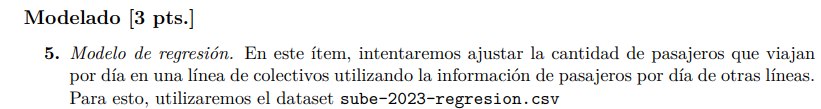

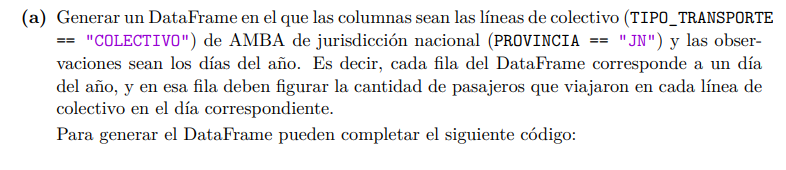

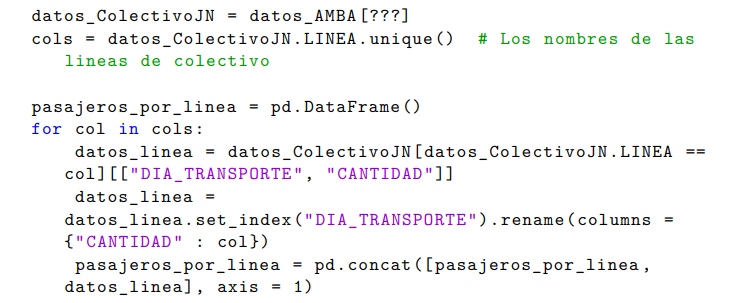

In [ ]:
datos_regresion = pd.read_csv('sube-2023-regresion.csv')

In [ ]:
datos_regresion.head()

In [ ]:
datos_ColectivoJN = datos_regresion[(datos_regresion['AMBA'] == 'SI') & (datos_regresion['PROVINCIA'] == 'JN') & (datos_regresion['TIPO_TRANSPORTE'] == 'COLECTIVO')]

cols = datos_ColectivoJN['LINEA'].unique()
pasajeros_por_linea = pd.DataFrame()

for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN['LINEA'] == col][['DIA_TRANSPORTE', 'CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns={'CANTIDAD': col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis=1)


In [ ]:
pasajeros_por_linea.head()

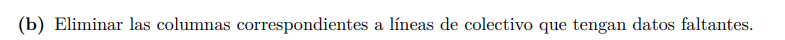

In [ ]:
pasajeros_por_linea.isnull().values.any() #Este comando nos indica si hay valores nulos

In [ ]:
# Eliminamos las columnas con datos faltantes
pasajeros_por_linea = pasajeros_por_linea.dropna(axis = 1)
# Chequeamos que no hayan quedado valores nulos
pasajeros_por_linea.isnull().values.any()

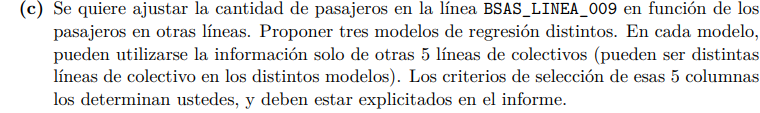